✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.

🧹 Đang cố gắng dọn dẹp bộ nhớ...
✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.

✅ Đã tìm thấy các file .npz trong 'E:/tmp_sliding_chunks' và scaler trong 'E:/tmp_scalers'. Đang tải...
✅ Đã tải các scaler từ file.
✅ Đã tìm thấy 109 file .npz. Đang tải dữ liệu...

⏳ Đang đếm tổng số mẫu từ các file NPZ (chỉ chạy một lần)...
✅ Tổng số mẫu được tải: 905484

📊 Tổng số mẫu: 905484
📚 Số samples cho tập Train: 543232 (khoảng 4244 batches)
🧪 Số samples cho tập Validation: 180992 (khoảng 1414 batches)
🎯 Số samples cho tập Test: 181098 (số lượng thực tế sẽ là 181098 nếu batch cuối cùng đủ hoặc nhỏ hơn)
✅ Hoàn thành chia tập dữ liệu.

🚀 Bắt đầu huấn luyện mô hình...
📈 Số lượng đặc trưng (num_features) được tự động phát hiện: 11
Epoch 1/50
   4244/Unknown - 396s 91ms/step - loss: 0.2774 - mae: 0.3000
Epoch 1: val_loss improved from inf to 0.07138, saving model to .\best_model_weights.weights.h5
4244/4244 [=================

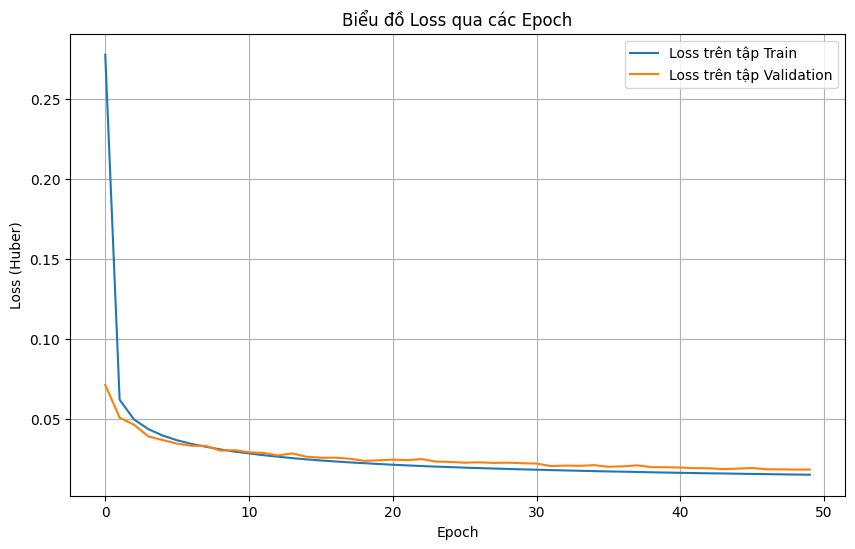

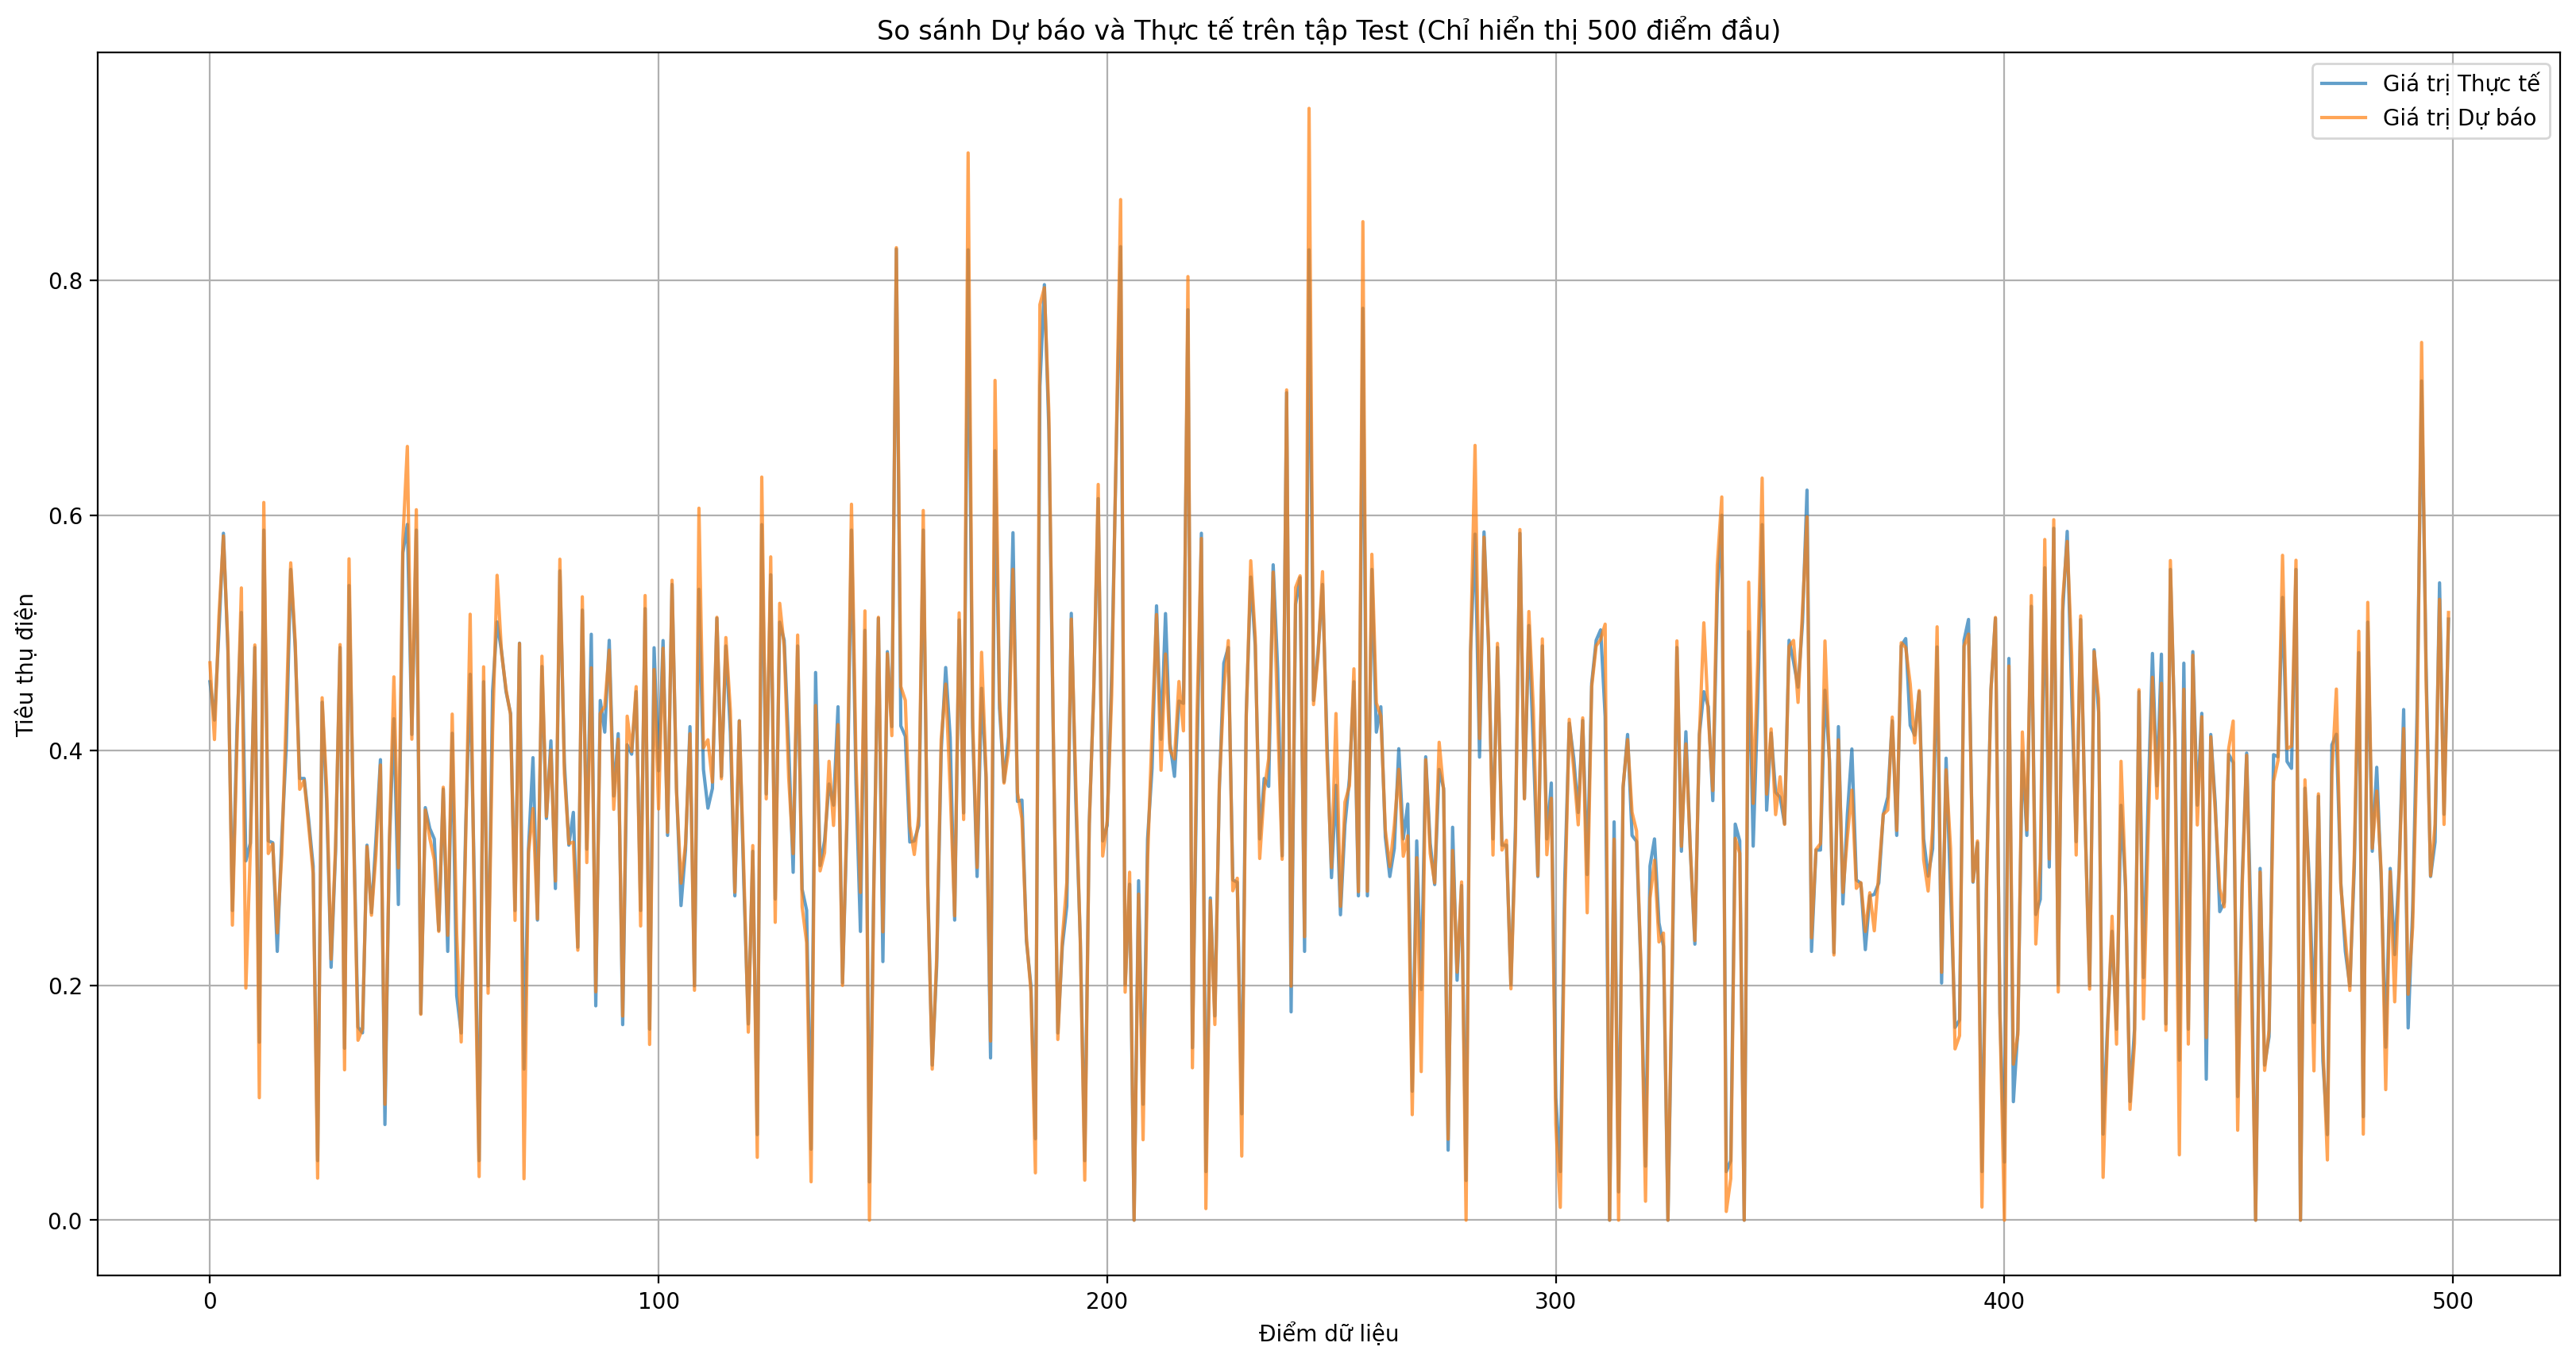

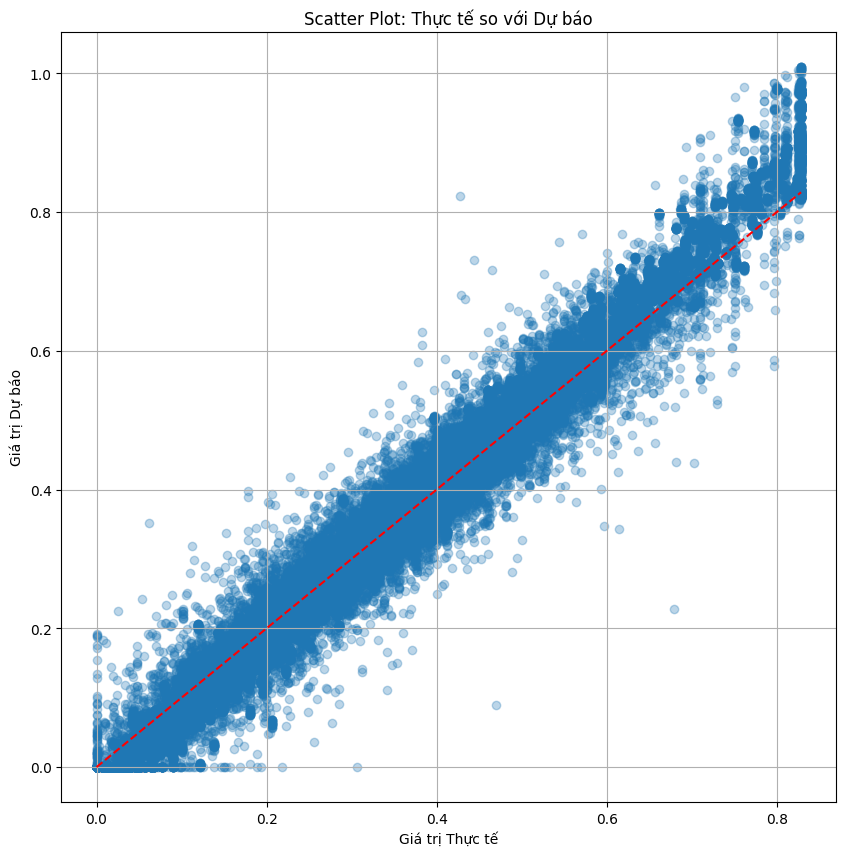


Tổng thời gian chạy toàn bộ pipeline: 23502.34 giây


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc
import joblib
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")

FILE_PATH = 'C:/CODE/Python/11gb_data.csv'
TEMP_CHUNKS_DIR = 'E:/tmp_sliding_chunks'
SCALER_DIR = 'E:/tmp_scalers'

os.makedirs(TEMP_CHUNKS_DIR, exist_ok=True)
os.makedirs(SCALER_DIR, exist_ok=True)

WINDOW_SIZE = 48
HORIZON = 24
STRIDE = HORIZON

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000

def read_and_resample_chunks(csv_path, chunk_size=300_000):
    all_resampled_data = []
    print(f"📦 Đang bắt đầu quá trình đọc và resample chunk từ file CSV '{csv_path}'...")
    chunks = pd.read_csv(csv_path, parse_dates=['Timestamp'], chunksize=chunk_size)

    for i, chunk in enumerate(chunks):
        if chunk.empty:
            print(f"Chunk {i} rỗng, bỏ qua.")
            continue
        print(f"⏳ Đang xử lý Chunk {i} ({len(chunk)} dòng)...")
        
        chunk = chunk.set_index('Timestamp').sort_index()

        chunk['hour_sin'] = np.sin(2 * np.pi * chunk.index.hour / 24)
        chunk['hour_cos'] = np.cos(2 * np.pi * chunk.index.hour / 24)
        chunk['dayofweek_sin'] = np.sin(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofweek_cos'] = np.cos(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofyear_sin'] = np.sin(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['dayofyear_cos'] = np.cos(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['is_weekend'] = (chunk.index.dayofweek >= 5).astype(int)

        if 'Anomaly_Label' in chunk.columns:
            chunk = chunk.drop(columns=['Anomaly_Label'])
        
        if 'Meter_ID' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID'])
        if 'Meter_ID_Numeric' in chunk.columns:
                chunk = chunk.drop(columns=['Meter_ID_Numeric'])

        numeric_chunk = chunk.select_dtypes(include=[np.number])

        numeric_chunk = numeric_chunk.interpolate(method='time', limit_direction='both')
        resampled_chunk = numeric_chunk.resample('1h').mean()
        resampled_chunk = resampled_chunk.ffill().bfill()
        
        if resampled_chunk.isnull().any().any():
            print(f"Cảnh báo: Chunk {i} vẫn còn giá trị NaN sau khi resample. Đang điền bằng trung bình cột.")
            resampled_chunk = resampled_chunk.fillna(resampled_chunk.mean())

        target_column_name = resampled_chunk.columns[0]
        Q1 = resampled_chunk[target_column_name].quantile(0.01)
        Q99 = resampled_chunk[target_column_name].quantile(0.99)
        resampled_chunk[target_column_name] = np.clip(resampled_chunk[target_column_name], Q1, Q99)
        
        for lag in [1, 24, 24*7]:
            resampled_chunk[f'{target_column_name}_lag_{lag}h'] = resampled_chunk[target_column_name].shift(lag)

        resampled_chunk = resampled_chunk.dropna()

        if not resampled_chunk.empty:
            all_resampled_data.append(resampled_chunk)
        print(f"✅ Hoàn thành xử lý Chunk {i}.")
        gc.collect()

    if not all_resampled_data:
        raise ValueError("Không có dữ liệu hợp lệ nào sau khi xử lý tất cả các chunk.")

    full_resampled_df = pd.concat(all_resampled_data)
    print(f"✅ Đã tổng hợp tất cả dữ liệu resample. Tổng số dòng: {len(full_resampled_df)}")
    gc.collect()
    return full_resampled_df

def sliding_save_chunks(data, input_seq_len, output_seq_len, stride, chunk_size, save_dir):
    
    total_len = input_seq_len + output_seq_len
    
    X_all = []
    y_all = []
    
    num_samples = data.shape[0] - total_len + 1 
    num_full_chunks = num_samples // chunk_size 
    
    print(f"📊 Tổng số mẫu có thể tạo: {num_samples}")
    print(f"📦 Sẽ tạo khoảng {num_full_chunks + (1 if num_samples % chunk_size != 0 else 0)} file .npz.")

    current_idx = 0
    chunk_file_idx = 0

    while current_idx < num_samples:
        start_chunk_idx = current_idx
        end_chunk_idx = min(current_idx + chunk_size, num_samples)
        
        X_chunk_list = []
        y_chunk_list = []

        for j in range(start_chunk_idx, end_chunk_idx, stride):
            if j + total_len <= data.shape[0]:
                X_sample = data[j : j + input_seq_len]
                y_sample = data[j + input_seq_len : j + total_len, 0]
                X_chunk_list.append(X_sample)
                y_chunk_list.append(y_sample)
            else:
                break

        if X_chunk_list:
            X_chunk_arr = np.array(X_chunk_list, dtype=np.float32)
            y_chunk_arr = np.array(y_chunk_list, dtype=np.float32)
            
            save_path = f"{save_dir}/chunk_{chunk_file_idx}.npz"
            np.savez(save_path, X=X_chunk_arr, y=y_chunk_arr)
            print(f"  💾 Đã lưu {X_chunk_arr.shape[0]} mẫu vào '{save_path}' (không nén)")
            chunk_file_idx += 1
        
        current_idx = end_chunk_idx

        del X_chunk_list, y_chunk_list, X_chunk_arr, y_chunk_arr
        gc.collect()

def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True, num_features_known=None):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X']
        y = data['y']
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    if num_features_known is None:
        element_spec_x = tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32)
    else:
        element_spec_x = tf.TensorSpec(shape=(WINDOW_SIZE, num_features_known), dtype=tf.float32)
    
    element_spec_y = tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(element_spec_x, element_spec_y)
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

class Informer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, output_seq_len, dropout=0.3):
        super().__init__()
        self.input_dense = tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3))
        self.pos_encoding = PositionalEncoding(input_seq_len, d_model)

        self.encoder_layers = []
        for _ in range(num_layers):
            self.encoder_layers.append({
                'mha': tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads),
                'dropout1': Dropout(dropout),
                'norm1': tf.keras.layers.LayerNormalization(epsilon=1e-6),
                'dense_proj': tf.keras.Sequential([
                    tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=l2(1e-3)),
                    BatchNormalization(),
                    tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3)),
                ]),
                'dropout2': Dropout(dropout),
                'norm2': tf.keras.layers.LayerNormalization(epsilon=1e-6)
            })

        self.final_dense = tf.keras.layers.Dense(output_seq_len)

    def call(self, x, training=False):
        x = self.input_dense(x)
        x = self.pos_encoding(x)

        for layer in self.encoder_layers:
            attn_output = layer['mha'](x, x, attention_mask=None, training=training)
            attn_output = layer['dropout1'](attn_output, training=training)
            x = layer['norm1'](x + attn_output)

            proj_output = layer['dense_proj'](x)
            proj_output = layer['dropout2'](proj_output, training=training)
            x = layer['norm2'](x + proj_output)

        x = tf.reduce_mean(x, axis=1)
        return self.final_dense(x)

if __name__ == '__main__':
    start_time_full_process = time.time()
    
    print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ...")
    tf.keras.backend.clear_session() 
    gc.collect() 
    print("✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.")

    existing_npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR, '*.npz'))
    existing_scaler_files = glob.glob(os.path.join(SCALER_DIR, '*.pkl'))

    if not existing_npz_files or not existing_scaler_files:
        print("\n⏳ Không tìm thấy các file NPZ hoặc Scaler. Bắt đầu tiền xử lý dữ liệu và tạo file...")
        
        resampled_df = read_and_resample_chunks(FILE_PATH)
        
        target_column_name = resampled_df.columns[0]

        selected_features = [
            target_column_name,
            f'{target_column_name}_lag_1h',
            f'{target_column_name}_lag_24h',
            f'{target_column_name}_lag_168h', 
            'hour_sin',
            'hour_cos',
            'dayofweek_sin',
            'dayofweek_cos',
            'dayofyear_sin', 
            'dayofyear_cos', 
            'is_weekend',
        ]

        existing_selected_features = [col for col in selected_features if col in resampled_df.columns]
        if 'Temperature' not in resampled_df.columns and 'Temperature' in selected_features:
            print("⚠️ Cảnh báo: Cột 'Temperature' không tồn tại trong dữ liệu sau resample và sẽ bị bỏ qua.")

        data_for_scaling = resampled_df[existing_selected_features].values
        print(f"📊 Dữ liệu sau tiền xử lý và chọn đặc trưng: shape {data_for_scaling.shape}")

        print("💡 Đang fit và transform scaler toàn cục...")
        target_scaler = StandardScaler()
        feature_scaler = StandardScaler()

        target_scaled = target_scaler.fit_transform(data_for_scaling[:, 0].reshape(-1, 1))
        features_scaled = feature_scaler.fit_transform(data_for_scaling[:, 1:])

        data_scaled = np.concatenate((target_scaled, features_scaled), axis=1)
        print("✅ Hoàn thành chuẩn hóa dữ liệu.")
        
        joblib.dump(target_scaler, os.path.join(SCALER_DIR, 'target_scaler.pkl'))
        joblib.dump(feature_scaler, os.path.join(SCALER_DIR, 'feature_scaler.pkl'))
        print(f"✅ Đã lưu các scaler vào '{SCALER_DIR}'.")

        print(f"\n💾 Đang tạo và lưu sliding windows vào thư mục: {TEMP_CHUNKS_DIR}...")
        
        SLIDING_CHUNK_SIZE = 50_000 
        sliding_save_chunks(data_scaled, WINDOW_SIZE, HORIZON, stride=STRIDE, 
                            chunk_size=SLIDING_CHUNK_SIZE, save_dir=TEMP_CHUNKS_DIR) 
        print("✅ Hoàn thành tạo và lưu sliding windows.")
        
        del resampled_df, data_for_scaling, target_scaled, features_scaled, data_scaled
        gc.collect()

    else:
        print(f"\n✅ Đã tìm thấy các file .npz trong '{TEMP_CHUNKS_DIR}' và scaler trong '{SCALER_DIR}'. Đang tải...")
        try:
            target_scaler = joblib.load(os.path.join(SCALER_DIR, 'target_scaler.pkl'))
            feature_scaler = joblib.load(os.path.join(SCALER_DIR, 'feature_scaler.pkl'))
            print("✅ Đã tải các scaler từ file.")
        except Exception as e:
            print(f"❌ Lỗi khi tải scaler: {e}. Vui lòng xóa '{SCALER_DIR}' và chạy lại.")
            exit()

    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR, '*.npz'))
    if not npz_files:
        print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR}'. Vui lòng kiểm tra đường dẫn hoặc chạy lại tiền xử lý.")
        exit()

    print(f"✅ Đã tìm thấy {len(npz_files)} file .npz. Đang tải dữ liệu...")
    
    sample_data = np.load(npz_files[0])
    sample_X_shape = sample_data['X'].shape
    num_features_in_npz = sample_X_shape[-1]
    del sample_data, sample_X_shape

    full_dataset_from_npz = load_npz_dataset(npz_files, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                                             shuffle=True,
                                             num_features_known=num_features_in_npz)
    
    print("\n⏳ Đang đếm tổng số mẫu từ các file NPZ (chỉ chạy một lần)...")
    total_samples = 0
    try:
        temp_dataset_for_counting = full_dataset_from_npz.unbatch()
        for _ in temp_dataset_for_counting.as_numpy_iterator():
            total_samples += 1
    except Exception as e:
        print(f"⚠️ Cảnh báo: Lỗi khi đếm mẫu bằng as_numpy_iterator: {e}. Đang thử đếm thủ công.")
        total_samples = 0
        for filepath in npz_files:
            data = np.load(filepath)
            total_samples += data['X'].shape[0]
            data.close()
        print(f"✅ Tổng số mẫu được tải (đếm thủ công): {total_samples}")

    print(f"✅ Tổng số mẫu được tải: {total_samples}")
    
    full_dataset_from_npz = load_npz_dataset(npz_files, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                                             shuffle=True,
                                             num_features_known=num_features_in_npz)
    
    train_size = int(0.6 * total_samples)
    val_size = int(0.2 * total_samples)
    test_size = total_samples - train_size - val_size

    train_batches = train_size // BATCH_SIZE
    val_batches = val_size // BATCH_SIZE

    train_dataset = full_dataset_from_npz.take(train_batches)
    val_dataset = full_dataset_from_npz.skip(train_batches).take(val_batches)
    test_dataset = full_dataset_from_npz.skip(train_batches + val_batches)

    print(f"\n📊 Tổng số mẫu: {total_samples}")
    print(f"📚 Số samples cho tập Train: {train_batches * BATCH_SIZE} (khoảng {train_batches} batches)")
    print(f"🧪 Số samples cho tập Validation: {val_batches * BATCH_SIZE} (khoảng {val_batches} batches)")
    print(f"🎯 Số samples cho tập Test: {test_size} (số lượng thực tế sẽ là {test_size} nếu batch cuối cùng đủ hoặc nhỏ hơn)")
    print("✅ Hoàn thành chia tập dữ liệu.")

    print("\n🚀 Bắt đầu huấn luyện mô hình...")
    start_train = time.time()

    num_features = num_features_in_npz
    print(f"📈 Số lượng đặc trưng (num_features) được tự động phát hiện: {num_features}")

    model = Informer(
        num_layers=3,   
        d_model=192,    
        num_heads=8,    
        dff=768,        
        input_seq_len=WINDOW_SIZE,
        output_seq_len=HORIZON,
        dropout=0.2     
    )
    
    dummy_X = tf.zeros((1, WINDOW_SIZE, num_features), dtype=tf.float32)
    _ = model(dummy_X)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss=tf.keras.losses.Huber(),
        metrics=['mae']
    )

    checkpoint_filepath = './best_model_weights.weights.h5'
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1), # Tăng patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7),
        ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    print(f"✅ Huấn luyện hoàn tất sau {time.time() - start_train:.2f} giây")

    try:
        model.load_weights(checkpoint_filepath)
        print(f"✅ Đã tải lại trọng số tốt nhất từ '{checkpoint_filepath}'")
    except Exception as e:
        print(f"⚠️ Không tìm thấy trọng số tốt nhất để tải lại hoặc có lỗi: {e}")
        print("Mô hình sẽ tiếp tục với trọng số cuối cùng của quá trình huấn luyện.")

    print("\n📈 Đang dự báo trên tập test...")
    start_test = time.time()
    
    y_true_list = []
    y_pred_list = []

    for X_batch, y_batch in test_dataset:
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_true_list.append(y_batch.numpy())
        y_pred_list.append(y_pred_batch)

    y_true_all_scaled = np.concatenate(y_true_list, axis=0)
    y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)

    print(f"✅ Dự báo hoàn tất sau {time.time() - start_test:.2f} giây")

    true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
    predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

    true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
    predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

    predicted[predicted < 0] = 0
    true[true < 0] = 0

    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
        return 100 * np.mean(numerator / denominator)

    print("\n📊 Evaluation on Test Set:")
    print(f"MAE  = {mean_absolute_error(true, predicted):.4f}")
    print(f"MSE  = {mean_squared_error(true, predicted):.4f}")
    print(f"RMSE = {np.sqrt(mean_squared_error(true, predicted)):.4f}")

    epsilon = 1e-8
    mape = np.mean(np.abs((true - predicted) / (true + epsilon))) * 100
    print(f"MAPE = {mape:.2f}%")
    print(f"sMAPE= {smape(true, predicted):.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss trên tập Train')
    plt.plot(history.history['val_loss'], label='Loss trên tập Validation')
    plt.title('Biểu đồ Loss qua các Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Huber)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 10), dpi=200)
    sample_size = 500
    plot_true = true[:sample_size] if len(true) >= sample_size else true
    plot_predicted = predicted[:sample_size] if len(predicted) >= sample_size else predicted

    plt.plot(plot_true, label='Giá trị Thực tế', alpha=0.7)
    plt.plot(plot_predicted, label='Giá trị Dự báo', alpha=0.7)
    plt.legend()
    plt.title(f'So sánh Dự báo và Thực tế trên tập Test (Chỉ hiển thị {len(plot_true)} điểm đầu)')
    plt.xlabel('Điểm dữ liệu')
    plt.ylabel('Tiêu thụ điện')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.scatter(true, predicted, alpha=0.3)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự báo')
    plt.title('Scatter Plot: Thực tế so với Dự báo')
    plt.grid(True)
    plt.show()

    print(f"\nTổng thời gian chạy toàn bộ pipeline: {time.time() - start_time_full_process:.2f} giây")

--- Khởi tạo và chuẩn bị môi trường vẽ biểu đồ ---
✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.
-------------------------------------------------
✅ Đã định nghĩa tất cả các hàm và lớp.

🧹 Đang cố gắng dọn dẹp bộ nhớ TensorFlow...
✅ Đã hoàn tất dọn dẹp bộ nhớ.

--- Đang tải scaler, mô hình và chạy dự báo ---
✅ Đã tải các scaler từ file.
📈 Số lượng đặc trưng (num_features) được tự động phát hiện: 11
✅ Đã tải lại trọng số tốt nhất từ 'E:/tmp_scalers/best_model_weights.weights.h5'
✅ Tổng số mẫu được tải (đếm từ file NPZ): 905484

⏳ Đang tải dữ liệu tập Test để dự báo...

📈 Đang chạy dự báo trên tập test để lấy dữ liệu cho biểu đồ...
✅ Dự báo hoàn tất sau 202.33 giây.
✅ Đã tạo biến 'true' và 'predicted' thành công và sẵn sàng để vẽ.

📊 Đánh giá trên tập Test (tính toán lại):
MAE  = 0.0302
MSE  = 0.0019
RMSE = 0.0435
MAPE = 846652.34%
sMAPE= 15.04%


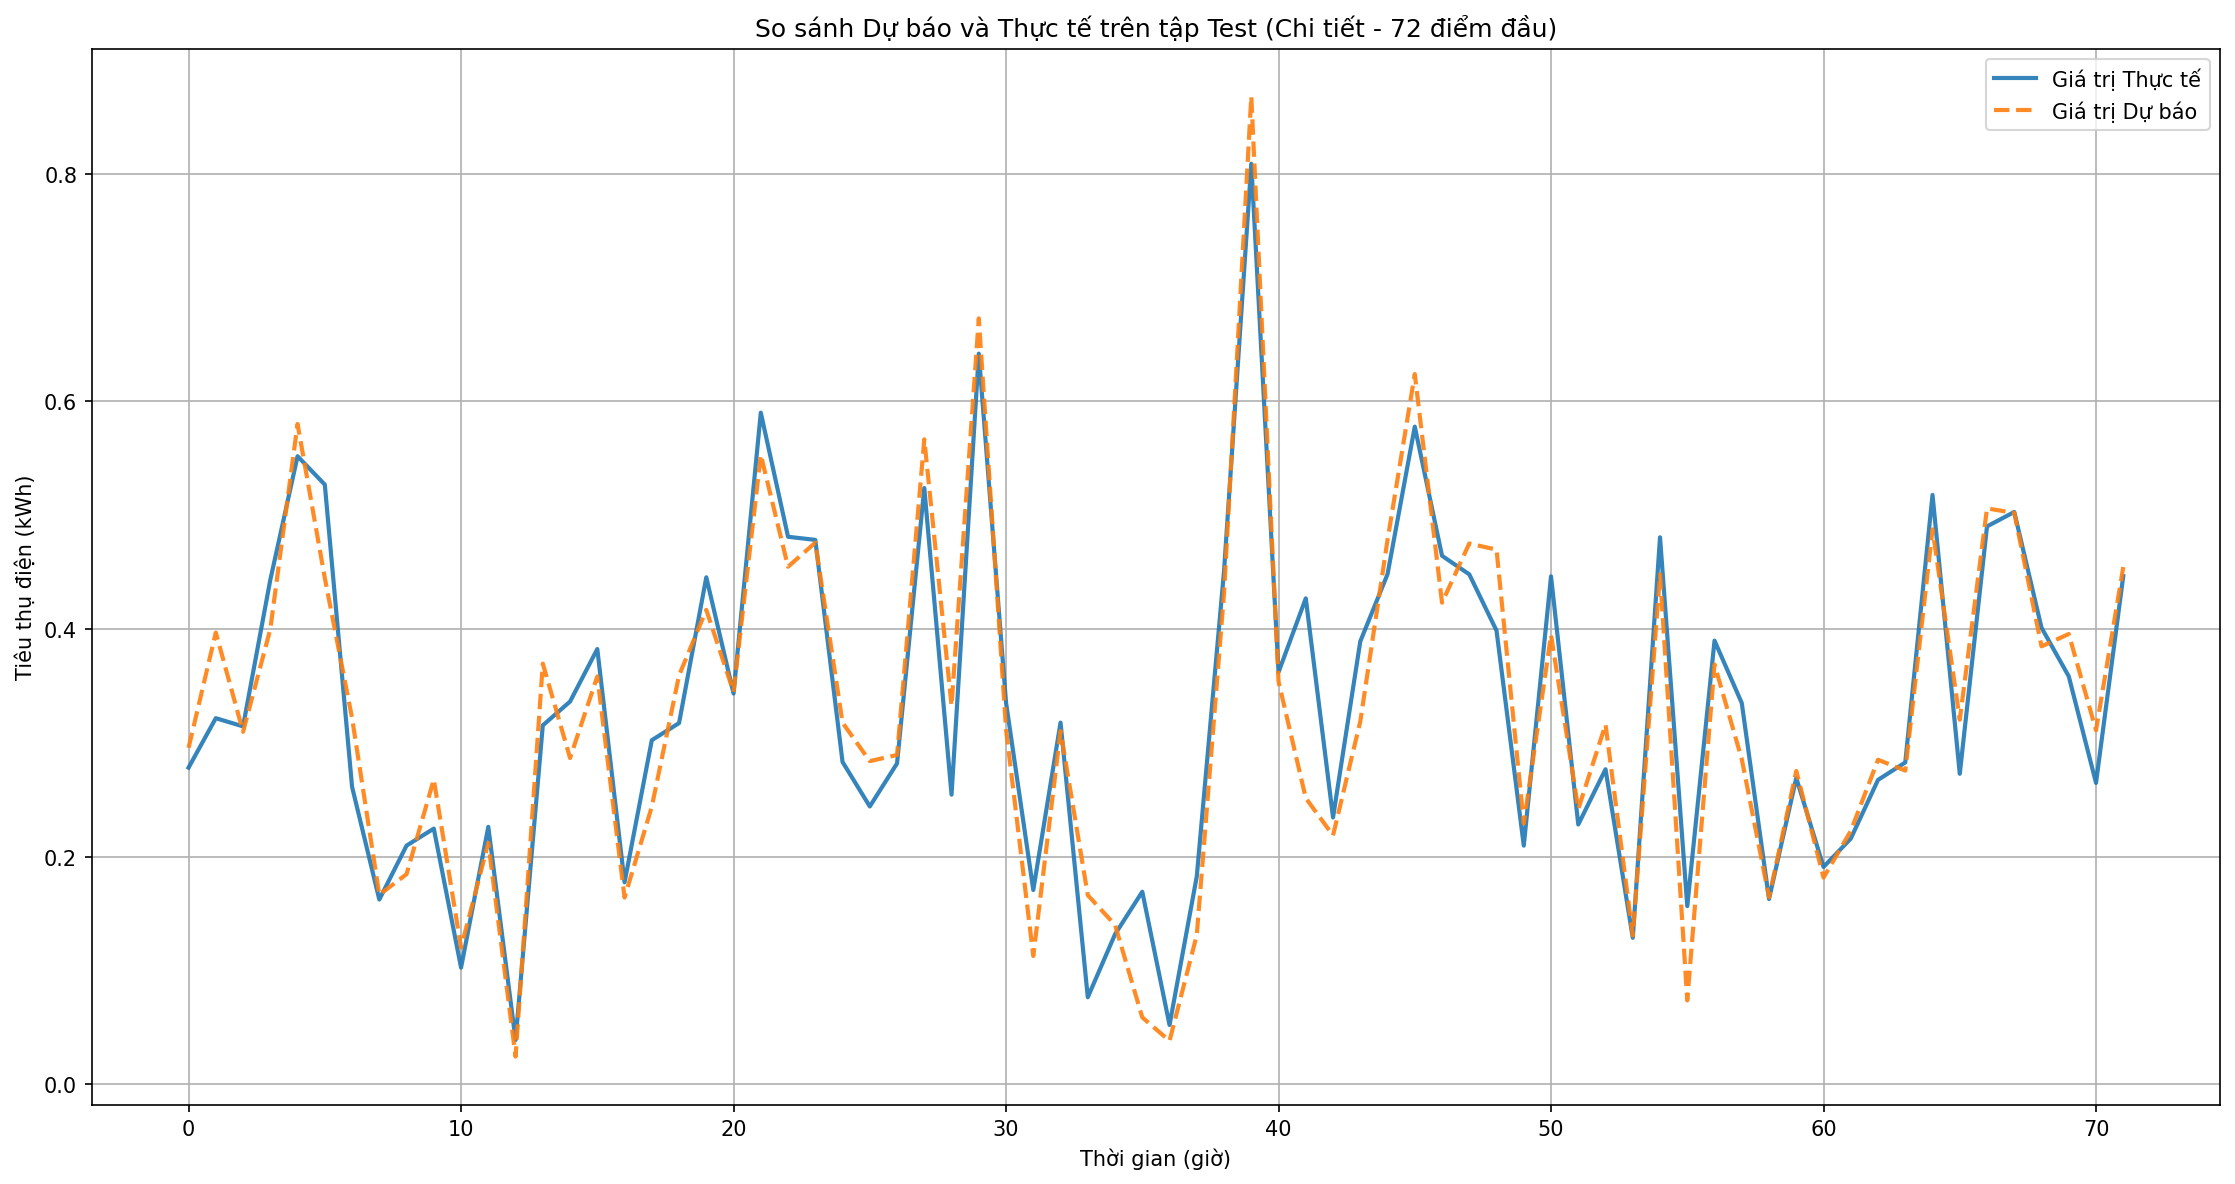


--- Hoàn tất quá trình vẽ biểu đồ ---


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
import gc
import joblib

print("--- Khởi tạo và chuẩn bị môi trường vẽ biểu đồ ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")
print("-------------------------------------------------")

# --- HẰNG SỐ (Đảm bảo khớp với cài đặt huấn luyện của bạn) ---
TEMP_CHUNKS_DIR = 'E:/tmp_sliding_chunks'
SCALER_DIR = 'E:/tmp_scalers'
WINDOW_SIZE = 48
HORIZON = 24
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000 # Không thực sự dùng cho việc tải test set không shuffle, nhưng giữ cho đầy đủ

# --- Định nghĩa các hàm và lớp cần thiết ---
# (Các hàm read_and_resample_chunks và sliding_save_chunks không cần thiết ở đây vì đã có NPZ và Scaler)

def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X']
        y = data['y']
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(
                    tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32), 
                    tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32)          
                )
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

class Informer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, output_seq_len, dropout=0.3):
        super().__init__()
        self.input_dense = tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3))
        self.pos_encoding = PositionalEncoding(input_seq_len, d_model)

        self.encoder_layers = []
        for _ in range(num_layers):
            self.encoder_layers.append({
                'mha': tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads),
                'dropout1': Dropout(dropout),
                'norm1': tf.keras.layers.LayerNormalization(epsilon=1e-6),
                'dense_proj': tf.keras.Sequential([
                    tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=l2(1e-3)),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3)),
                ]),
                'dropout2': Dropout(dropout),
                'norm2': tf.keras.layers.LayerNormalization(epsilon=1e-6)
            })

        self.final_dense = tf.keras.layers.Dense(output_seq_len)

    def call(self, x, training=False):
        x = self.input_dense(x)
        x = self.pos_encoding(x)

        for layer in self.encoder_layers:
            attn_output = layer['mha'](x, x, attention_mask=None, training=training)
            attn_output = layer['dropout1'](attn_output, training=training)
            x = layer['norm1'](x + attn_output)

            proj_output = layer['dense_proj'](x)
            proj_output = layer['dropout2'](proj_output, training=training)
            x = layer['norm2'](x + proj_output)

        x = tf.reduce_mean(x, axis=1)
        return self.final_dense(x)

def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
    return 100 * np.mean(numerator / denominator)

print("✅ Đã định nghĩa tất cả các hàm và lớp.")

# --- Dọn dẹp bộ nhớ và tải lại các thành phần đã lưu ---
print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ TensorFlow...")
tf.keras.backend.clear_session() 
gc.collect() 
print("✅ Đã hoàn tất dọn dẹp bộ nhớ.")

print(f"\n--- Đang tải scaler, mô hình và chạy dự báo ---")

# Tải lại scaler
target_scaler = None
feature_scaler = None
try:
    target_scaler = joblib.load(os.path.join(SCALER_DIR, 'target_scaler.pkl'))
    feature_scaler = joblib.load(os.path.join(SCALER_DIR, 'feature_scaler.pkl'))
    print("✅ Đã tải các scaler từ file.")
except Exception as e:
    print(f"❌ Lỗi khi tải scaler: {e}. Đảm bảo đường dẫn '{SCALER_DIR}' và các file .pkl tồn tại.")
    print("Vui lòng chạy lại toàn bộ quá trình tiền xử lý và huấn luyện nếu các file này bị thiếu.")
    exit() # Thoát nếu không thể tải scaler

npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR, '*.npz'))
if not npz_files:
    print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR}'. Vui lòng kiểm tra đường dẫn.")
    print("Vui lòng chạy lại toàn bộ quá trình tiền xử lý và huấn luyện nếu các file này bị thiếu.")
    exit() # Thoát nếu không tìm thấy file NPZ

# Xác định num_features bằng cách tải một file NPZ mẫu
sample_data = np.load(npz_files[0])
num_features = sample_data['X'].shape[-1]
sample_data.close() # Quan trọng để đóng file npz
print(f"📈 Số lượng đặc trưng (num_features) được tự động phát hiện: {num_features}")

# Khởi tạo mô hình và tải trọng số
model = Informer(
    num_layers=2,
    d_model=64,
    num_heads=8,
    dff=256,
    input_seq_len=WINDOW_SIZE,
    output_seq_len=HORIZON,
    dropout=0.3
)

# Build mô hình bằng cách gọi một lần với dữ liệu dummy
dummy_X = tf.zeros((1, WINDOW_SIZE, num_features), dtype=tf.float32)
_ = model(dummy_X)

checkpoint_filepath = 'E:/tmp_scalers/best_model_weights.weights.h5'
try:
    model.load_weights(checkpoint_filepath)
    print(f"✅ Đã tải lại trọng số tốt nhất từ '{checkpoint_filepath}'")
except Exception as e:
    print(f"⚠️ Lỗi khi tải trọng số mô hình: {e}. Đảm bảo file '{checkpoint_filepath}' tồn tại.")
    print("Dự đoán sẽ không chính xác nếu trọng số không được tải.")

# Lấy tổng số mẫu để chia dataset (để xác định tập test)
total_samples = 0
for filepath in npz_files:
    data_temp = np.load(filepath)
    total_samples += data_temp['X'].shape[0]
    data_temp.close() 
print(f"✅ Tổng số mẫu được tải (đếm từ file NPZ): {total_samples}")

# Chia kích thước tập dữ liệu
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
train_batches = train_size // BATCH_SIZE
val_batches = val_size // BATCH_SIZE

# Tải dataset test (quan trọng: shuffle=False để dữ liệu test giữ nguyên thứ tự thời gian)
print("\n⏳ Đang tải dữ liệu tập Test để dự báo...")
full_dataset_from_npz_for_test = load_npz_dataset(npz_files, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=False) 
test_dataset = full_dataset_from_npz_for_test.skip(train_batches + val_batches)

y_true_list = []
y_pred_list = []

print("\n📈 Đang chạy dự báo trên tập test để lấy dữ liệu cho biểu đồ...")
start_predict_time = time.time()
for X_batch, y_batch in test_dataset:
    y_pred_batch = model.predict(X_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(y_pred_batch)

y_true_all_scaled = np.concatenate(y_true_list, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)
print(f"✅ Dự báo hoàn tất sau {time.time() - start_predict_time:.2f} giây.")

# Lấy giá trị dự báo và thực tế cho bước đầu tiên (điểm dự báo đầu tiên)
true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

# Đảo ngược chuẩn hóa
true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

# Đảm bảo không có giá trị âm
predicted[predicted < 0] = 0
true[true < 0] = 0

print("✅ Đã tạo biến 'true' và 'predicted' thành công và sẵn sàng để vẽ.")

# --- Tính toán lại các chỉ số đánh giá ---
print("\n📊 Đánh giá trên tập Test (tính toán lại):")
mae = mean_absolute_error(true, predicted)
mse = mean_squared_error(true, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((true - predicted) / (true + 1e-8))) * 100
s_mape = smape(true, predicted) 

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")
print(f"sMAPE= {s_mape:.2f}%")

# Biểu đồ 2: So sánh Dự báo và Thực tế trên tập Test (ít mẫu để xem chi tiết)
if 'true' in locals() and 'predicted' in locals():
    plt.figure(figsize=(15, 8), dpi=150) # Kích thước nhỏ hơn, dpi có thể giữ nguyên hoặc giảm
    
    # Số điểm dữ liệu bạn muốn hiển thị (ví dụ: 72 điểm = 3 ngày)
    sample_size_for_detail = 72 
    
    plot_true_detail = true[:sample_size_for_detail]
    plot_predicted_detail = predicted[:sample_size_for_detail]

    plt.plot(plot_true_detail, label='Giá trị Thực tế', alpha=0.9, linewidth=2)
    plt.plot(plot_predicted_detail, label='Giá trị Dự báo', alpha=0.9, linestyle='--', linewidth=2)
    plt.legend()
    plt.title(f'So sánh Dự báo và Thực tế trên tập Test (Chi tiết - {len(plot_true_detail)} điểm đầu)')
    plt.xlabel('Thời gian (giờ)')
    plt.ylabel('Tiêu thụ điện (kWh)')
    plt.grid(True)
    plt.tight_layout() # Điều chỉnh bố cục để tránh chồng lấn
    plt.show()
else:
    print("Không thể vẽ biểu đồ So sánh Dự báo và Thực tế: Biến 'true' hoặc 'predicted' không tồn tại.")


print("\n--- Hoàn tất quá trình vẽ biểu đồ ---")

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout

# --- Định nghĩa lại các lớp tùy chỉnh (PositionalEncoding, Informer) ---
# Các lớp này phải giống hệt như trong code huấn luyện của bạn để Keras có thể tái tạo mô hình.
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

class Informer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, output_seq_len, dropout=0.3):
        super().__init__()
        self.input_dense = tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3))
        self.pos_encoding = PositionalEncoding(input_seq_len, d_model)

        self.encoder_layers = []
        for _ in range(num_layers):
            self.encoder_layers.append({
                'mha': tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads),
                'dropout1': Dropout(dropout),
                'norm1': tf.keras.layers.LayerNormalization(epsilon=1e-6),
                'dense_proj': tf.keras.Sequential([
                    tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=l2(1e-3)),
                    BatchNormalization(),
                    tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-3)),
                ]),
                'dropout2': Dropout(dropout),
                'norm2': tf.keras.layers.LayerNormalization(epsilon=1e-6)
            })

        self.final_dense = tf.keras.layers.Dense(output_seq_len)

    def call(self, x, training=False):
        x = self.input_dense(x)
        x = self.pos_encoding(x)

        for layer in self.encoder_layers:
            attn_output = layer['mha'](x, x, attention_mask=None, training=training)
            attn_output = layer['dropout1'](attn_output, training=training)
            x = layer['norm1'](x + attn_output)

            proj_output = layer['dense_proj'](x)
            proj_output = layer['dropout2'](proj_output, training=training)
            x = layer['norm2'](x + proj_output)

        x_last_step = x[:, -1, :] 
        
        return self.final_dense(x_last_step)

# --- Cấu hình GPU (tùy chọn, nếu bạn có GPU) ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(f"❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động: {e}")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")

# --- Đường dẫn đến file trọng số đã lưu ---
# Đảm bảo đường dẫn này đúng trên máy của bạn
WEIGHTS_FILE_PATH = "E:/tmp_scalers/best_model_weights.weights.h5" 

# --- Tham số mô hình (phải giống với lúc huấn luyện) ---
# RẤT QUAN TRỌNG: Các tham số này PHẢI khớp với các tham số bạn đã sử dụng để huấn luyện mô hình.
# Nếu không khớp, việc tải trọng số có thể thất bại hoặc mô hình hoạt động sai.
NUM_LAYERS = 3
D_MODEL = 192
NUM_HEADS = 8
DFF = 768
INPUT_SEQ_LEN = 48 # WINDOW_SIZE
OUTPUT_SEQ_LEN = 24 # HORIZON
DROPOUT = 0.2

# Số lượng đặc trưng đầu vào (quan trọng để build mô hình đúng kích thước)
NUM_FEATURES = 10 # Cần xác nhận lại số lượng đặc trưng chính xác của bạn

# --- 1. Xây dựng kiến trúc mô hình ---
print(f"🛠️ Đang xây dựng kiến trúc mô hình Informer với {NUM_FEATURES} đặc trưng đầu vào...")
model = Informer(
    num_layers=NUM_LAYERS, 
    d_model=D_MODEL, 
    num_heads=NUM_HEADS, 
    dff=DFF, 
    input_seq_len=INPUT_SEQ_LEN,
    output_seq_len=OUTPUT_SEQ_LEN,
    dropout=DROPOUT 
)

# Rất quan trọng: "Build" mô hình bằng cách chạy một lần với dummy input
# Điều này tạo ra các trọng số và xác định hình dạng của các lớp.
dummy_X = tf.zeros((1, INPUT_SEQ_LEN, NUM_FEATURES), dtype=tf.float32)
_ = model(dummy_X)
print("✅ Kiến trúc mô hình đã được xây dựng.")
model.summary()

# --- 2. Tải trọng số từ file .h5 ---
print(f"\n⏳ Đang tải trọng số từ '{WEIGHTS_FILE_PATH}'...")
try:
    model.load_weights(WEIGHTS_FILE_PATH)
    print("✅ Đã tải trọng số thành công.")
except Exception as e:
    print(f"❌ Lỗi khi tải trọng số từ '{WEIGHTS_FILE_PATH}': {e}")
    print("Vui lòng kiểm tra lại đường dẫn và đảm bảo file trọng số tồn tại và không bị hỏng.")
    exit()

# --- 3. Lưu toàn bộ mô hình sang định dạng SavedModel (KHUYẾN NGHỊ cho subclassed models) ---
# Lưu ý: SavedModel sẽ tạo ra một thư mục, không phải một file .h5 duy nhất.
FULL_MODEL_SAVE_PATH_TF = "./informer_full_model_for_streamlit_savedmodel" 

print(f"\n💾 Đang lưu toàn bộ mô hình (kiến trúc và trọng số) vào định dạng SavedModel tại '{FULL_MODEL_SAVE_PATH_TF}'...")
try:
    # Sử dụng save_format="tf" để lưu dưới định dạng SavedModel
    model.save(FULL_MODEL_SAVE_PATH_TF, save_format="tf")
    print(f"✅ Đã lưu toàn bộ mô hình Informer vào '{FULL_MODEL_SAVE_PATH_TF}' thành công.")
    print("\nBạn có thể sử dụng thư mục này trong ứng dụng Streamlit của mình.")
    print("Để tải lại trong Streamlit: model = tf.keras.models.load_model('INFORMER_FULL_MODEL_SAVE_PATH_TF', custom_objects={'Informer': Informer, 'PositionalEncoding': PositionalEncoding})")
except Exception as e:
    print(f"❌ Lỗi khi lưu toàn bộ mô hình vào '{FULL_MODEL_SAVE_PATH_TF}': {e}")
    print("Vui lòng kiểm tra phiên bản TensorFlow và các cài đặt quyền truy cập file.")
    print("Đảm bảo các lớp tùy chỉnh (PositionalEncoding, Informer) được định nghĩa chính xác và không có lỗi.")

✅ Đã cấu hình bộ nhớ GPU tăng trưởng động.
🛠️ Đang xây dựng kiến trúc mô hình Informer với 10 đặc trưng đầu vào...
✅ Kiến trúc mô hình đã được xây dựng.
Model: "informer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  2112      
                                                                 
 positional_encoding (Positi  multiple                 0         
 onalEncoding)                                                   
                                                                 
 sequential (Sequential)     (1, 48, 192)              298944    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                     

INFO:tensorflow:Assets written to: ./informer_full_model_for_streamlit_savedmodel\assets


INFO:tensorflow:Assets written to: ./informer_full_model_for_streamlit_savedmodel\assets


✅ Đã lưu toàn bộ mô hình Informer vào './informer_full_model_for_streamlit_savedmodel' thành công.

Bạn có thể sử dụng thư mục này trong ứng dụng Streamlit của mình.
Để tải lại trong Streamlit: model = tf.keras.models.load_model('INFORMER_FULL_MODEL_SAVE_PATH_TF', custom_objects={'Informer': Informer, 'PositionalEncoding': PositionalEncoding})


: 